# Explainable AI using SHAP

### Problem:  Identify the potential customers who have a higher probability of purchasing the loan. 
#### Problem Type: Binary Classification 
#### Description: This case is about a bank which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans.

##### Please note the emphasis of this notebook is to demonstrate the use of SHAP, so we will not be focusing on other aspects of ML such as EDA, Model Training & Optmization Process etc.


In [1]:
!pip install shap

In [5]:
import shap
import pandas as pd

## Data
##### Data  is taken from the kaggle dataset - # https://www.kaggle.com/itsmesunil/bank-loan-modelling#
##### There are 12 features. The aim is to construct a model that can identify potential customers who have higher probability of purchasing loan.
#### 0 - Non-Loan customers
#### 1 - Loan customers

#### Information on the features or attributes

The attributes can be divided accordingly :
* The variable **ID** does not add any interesting information. There is no association between a person's customer ID  and loan, also it does not provide any general conclusion for future potential loan customers. We can neglect this information for our model prediction.

The binary category have five variables as below:

* Personal Loan - Did this customer accept the personal loan offered in the last campaign? ** This is our target variable**
* Securities Account - Does the customer have a securities account with the bank?
* CD Account - Does the customer have a certificate of deposit (CD) account with the bank?
* Online - Does the customer use internet banking facilities?
* Credit Card - Does the customer use a credit card issued by UniversalBank?

Interval variables are as below:

* Age - Age of the customer
* Experience - Years of experience
* Income - Annual income in dollars
* CCAvg - Average credit card spending
* Mortage - Value of House Mortgage

Ordinal Categorical Variables are:
* Family - Family size of the customer
* Education - education level of the customer

The nominal variable is :

* ID
* Zip Code

In [7]:
loan_data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
loan_data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Looks quite clean, eh
Let us check for null values

In [8]:
loan_data['Personal Loan'].describe()

count    5000.000000
mean        0.096000
std         0.294621
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Personal Loan, dtype: float64

In [10]:
#check for the null values
loan_data.isnull().any().sum()

0

In [11]:
loan_data.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [9]:
loan_data.shape

(5000, 14)

In [ ]:
#ID won't be a valuable feature
loan_data.drop(columns = "ID", inplace = True)

In [12]:
#Since the intent is to predict personal loan, i.e. 1 if the loan is accepted, 0 if it isn't.
#separate the dataset into target variable and features
y = loan_data['Personal Loan']
X = loan_data.drop(columns=['Personal Loan'], inplace = False)

In [14]:
from sklearn.model_selection import train_test_split
#let us split the dataset into train (80%) and test sample (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Let us save column names, as they later will be feature names
columns = X_train.columns
columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online',
       'CreditCard'],
      dtype='object')

Let us run a well known model that often fits very well to training data, Random Forest.

In [26]:
from sklearn.ensemble import RandomForestClassifier

#fit the model based on the given training samples
rf_model=RandomForestClassifier(random_state=20)
rf_model.fit(X_train, y_train)

#get the accuracy of the model
rf_model.score(X_test, y_test)

0.989

That's an extremely well fitting model, which often isn't the case in real-life examples. But over-fitting, or model accuracy isn't our intention for this exercise.

# SHapley Additive exPlanations

In [42]:
#we need an instance of explainer for a tree-based model, i.e. our random forest (rf)
#Explainers are in-built methods of these libraries, customisable by the attributes they can take in
explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_test) #pass the first test sample, to see what influenced the first value. we can iterate for other values as well.




In [52]:
shap.initjs() #to make the visualization happen in the notebook environment
shap.force_plot(explainer.expected_value[0], shap_values=shap_values[0][5], features=X_test.iloc[5])

#explainer.expected_value[0] - take the first expe\cted value by explainer
#shap_values[0] - what value to describe, i.e the first value of X_test
#X.iloc[0,:] - We want all columns of data, except 'Personal loan' to be treated as features

In [40]:
X_test.iloc[5]

ID                      107.0
Age                      43.0
Experience               17.0
Income                   69.0
ZIP Code              92717.0
Family                    4.0
CCAvg                     2.9
Education                 1.0
Mortgage                  0.0
Securities Account        0.0
CD Account                0.0
Online                    1.0
CreditCard                1.0
Name: 106, dtype: float64

## Let us understand SHAP output

1. Features in red color are pushing value higher, to make it equal to the current class.
2. Features in blue color are pushing value lower, i.e away from our current class.
3. Current class: Since our first "Personal loan" value was 0, i.e loan not accepted, we can see red features are the ones pushing our prediction to 0, blue ones to 1.
4. The larger the feature block, the more important it is. 
5. Visually juding, since red overpowers blue, our predicton also called it a 0, i.e loan not accepted. 

In [21]:
#Let us pass the whole dataset now, and see which attribute interacts the most

#create an explainer for a tree-based model, i.e., random forest (rf)
explainer = shap.TreeExplainer(rf_model) 
shap_values = explainer.shap_values(X_test)#passing the entire dataset

## Sumary Plot — Global Interpretability

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.¶

SHAP summary plot. Low income increase the chance of not taking loan.

In the summary plot, we see first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots.

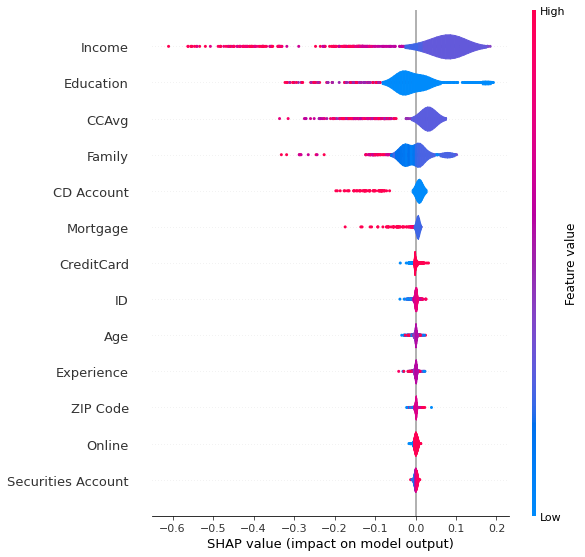

In [54]:
shap.summary_plot(shap_values[0], X_test, plot_type='violin', plot_size=0.6)

This plot shows all the data points in test data. Following can be concluded from this plot.

1. The graph displays important features in descending order. Most important features are the top.

2. The poistion of a point is associated with the impact of that particular value on the model.

3. Red colour indicates a higher value and blue indicates lower value. 

4. We remember red pushes value of probability of current class lower and away from current class. So, higher the income, lower the chances of current class, ie 0.

4. For eg: Median to High value of education also decreases the probability of current class.. 

In [ ]:
print(len(shap_values))
#1000 -> Total Customers in X_test and 11 -> Total Features
shap_values[1].shape

# SHAP Feature Importance
The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we sum the absolute Shapley values per feature across the data:

Next, we sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the random forest trained before for predicting loan accepted.

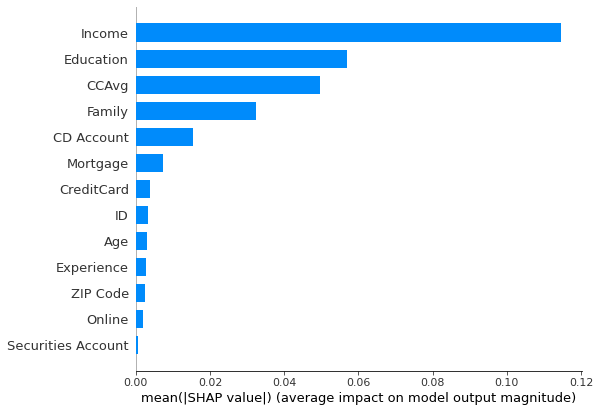

In [22]:
shap.summary_plot(shap_values[1], X, plot_type = "bar", show = False)

SHAP feature importance measured as the mean absolute Shapley values. 
Income was the most important feature, changing the predicted absolute not takingloan on average by 12 percentage points (0.12 on x-axis).

SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.

The feature importance plot is useful, but contains no information beyond the importances. For a more informative plot, we will next look at the summary plot.

## SHAP Dependence Plot
SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

#dependence_plot()method:
#shap.dependence_plot(<name of feature with what we want to find the relation of target variable>, <which SHAP value we want to consider(can be randomly any)>, <dataset>)

The following figure shows the SHAP feature dependence for years on hormonal contraceptives:

FIGURE 9.27: SHAP dependence plot for years on hormonal contraceptives. Compared to 0 years, a few years lower the predicted probability and a high number of years increases the predicted cancer probability.

SHAP dependence plots are an alternative to partial dependence plots and accumulated local effects. While PDP and ALE plot show average effects, SHAP dependence also shows the variance on the y-axis. Especially in case of interactions, the SHAP dependence plot will be much more dispersed in the y-axis. The dependence plot can be improved by highlighting these feature interactions.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


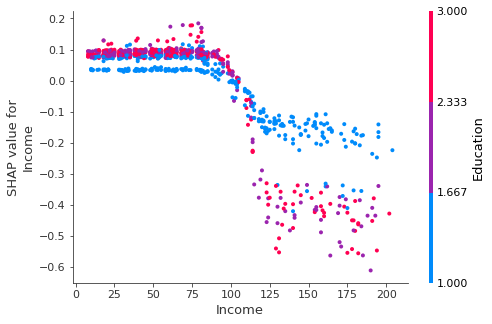

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


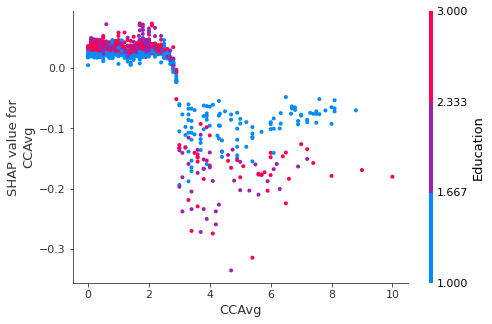

In [25]:

shap.dependence_plot("Income", shap_values[0], X_test)
shap.dependence_plot("CCAvg", shap_values[0], X_test)

We observe as the income increases, SHAP value of income decreases.
What does it mean?
Higher the income, lower the chances of being closer to current class, i.e 0 (Non Loaner)

Higher the income, lesser the chances of not accepting the loan.

Let us see the whole data features and their impact at once

In [ ]:
Observation : It seems the customers whose education level is 1 is having more income. However customers who has taken the personal loan have the same income levels
    
Observation: Customers who does not have CD account , does not have loan as well. This seems to be majority. But almost all customers who has CD account has loan as well

Observation: Customers who have personal loan have a higher credit card average. Average credit card spending with a median of 3800 dollar indicates a higher probability of personal loan. Lower credit card spending with a median of 1400 dollars is less likely to take a loan. This could be useful information.

## Individual SHAP Value Plot — Local Interpretability

In [33]:
X_test.iloc[15]

ID                     3544.0
Age                      37.0
Experience               11.0
Income                  194.0
ZIP Code              94303.0
Family                    2.0
CCAvg                     0.0
Education                 1.0
Mortgage                  0.0
Securities Account        0.0
CD Account                0.0
Online                    0.0
CreditCard                0.0
Name: 3543, dtype: float64

In [34]:
shap.initjs() #to make the visualization happen in the notebook environment
# shap.force_plot(explainer.expected_value[0], shap_values=shap_values[0], features=X.iloc[0, :])

#explainer.expected_value[0] - take the first expe\cted value by explainer
#shap_values[0] - what value to describe, i.e the first value of X_test
#X.iloc[0,:] - We want all columns of data, except 'Personal loan' to be treat
shap.force_plot(explainer.expected_value[0], shap_values[0][15], X_test.iloc[15])
# explainer.expected_value

In [ ]:
explainer.expected_value

# shap.waterfall_plot(shap_values, max_display=10, show=True)
Plots an explantion of a single prediction as a waterfall plot.

The SHAP value of a feature represents the impact of the evidence provided by that feature on the model’s output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature move the model output from our prior expectation under the background data distribution, to the final model prediction given the evidence of all the features. Features are sorted by the magnitude of their SHAP values with the smallest magnitude features grouped together at the bottom of the plot when the number of features in the models exceeds the max_display parameter.

### Parameters
shap_values 
A one-dimensional Explanation object that contains the feature values and SHAP values to plot.

max_display (str)
The maximum number of features to plot.

show (bool)
Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot to be customized further after it has been created.

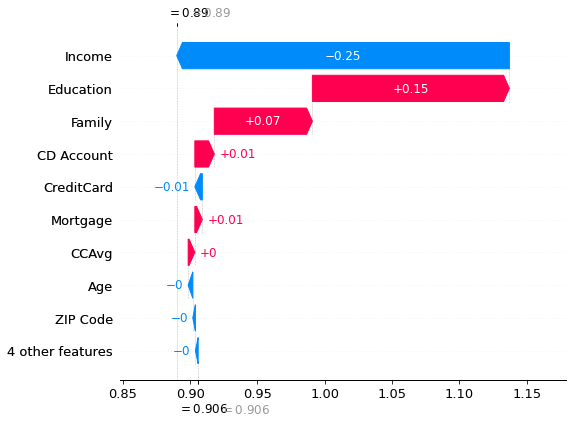

ID                     3544.0
Age                      37.0
Experience               11.0
Income                  194.0
ZIP Code              94303.0
Family                    2.0
CCAvg                     0.0
Education                 1.0
Mortgage                  0.0
Securities Account        0.0
CD Account                0.0
Online                    0.0
CreditCard                0.0
Name: 3543, dtype: float64

In [28]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][15], show = True, feature_names = columns)
X_test.iloc[15]

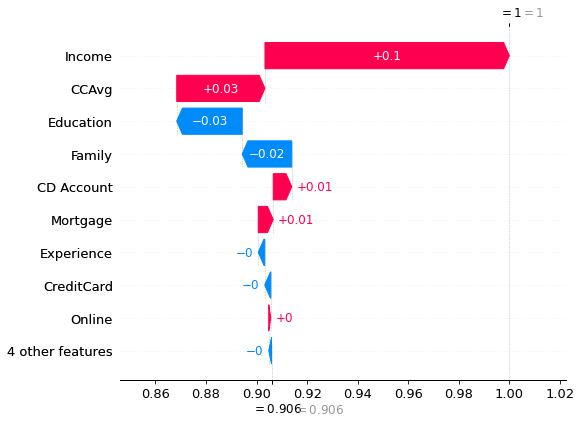

ID                     2465.0
Age                      60.0
Experience               36.0
Income                   32.0
ZIP Code              92407.0
Family                    3.0
CCAvg                     0.4
Education                 2.0
Mortgage                165.0
Securities Account        0.0
CD Account                0.0
Online                    1.0
CreditCard                0.0
Name: 2464, dtype: float64

In [29]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][10], show = True, feature_names = columns)
X_test.iloc[10]

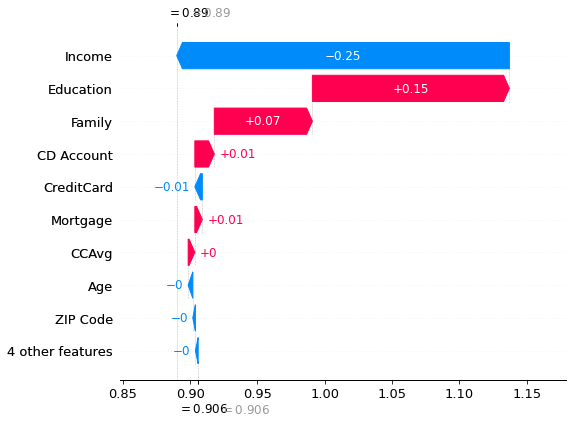

In [30]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][15], show = True, feature_names = columns)
# fig = plt.gcf()
# fig.set_figheight(10)
# fig.set_figwidth(14)
# ax = plt.gca()

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values[1][50], X.iloc[50])

#Benefits:
1. With SHAP we could tell which feature is more important
2. Impact of a particular feature on one target variable or the whole dataset as well

Let us not miss Lime, let us do that too.

#Local Interpretable Model-Agnostic Explanations

#LIME

Here, tabular explainer object takes in attributes training data, feature names, mode (classification or regression), and class names.

Now that the model is run, let us use explain_instance() to interpret the preddiction made by model. 
Foer classification problems, we use predict_proba to know probability of being assigned a particular class and for regression models (stock forecasting etc), we use actual prediction. 

1. Acc to prediction probabilities on top left, model is 100% sure that the current observation belongs to current class (0) ie not accepting a personal loan.
2. The second column shows the features listed in descending order of importance, and what factors contribute to making orediction either a 0 or 1.
3. The thrid column shows attributes with their actual values in this sample.